In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# 1. Load Data
data = "properties.csv"
df = pd.read_csv(data, encoding='utf-8')

print("Original Data Shape:", df.shape)
print(df.info())

/var/folders/_1/w3rmdmrx14qdr85c4l_crhq80000gn/T/ipykernel_9746/4269065727.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data, encoding='utf-8')


Original Data Shape: (1262519, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262519 entries, 0 to 1262518
Data columns (total 16 columns):
 #   Column                                          Non-Null Count    Dtype  
---  ------                                          --------------    -----  
 0   Building unit type                              1262519 non-null  object 
 1   Building Location                               1262519 non-null  object 
 2   Building Estate                                 1262519 non-null  object 
 3   District                                        1262519 non-null  object 
 4   Longitude                                       1262519 non-null  float64
 5   Latitude                                        1262519 non-null  float64
 6   Building Floor                                  1262190 non-null  object 
 7   Building Unit                                   1260570 non-null  object 
 8   Building Net Area                               1262519 n

In [53]:
# 2. Data Cleaning & Preprocessing
# Based on version_1.ipynb logic

# Drop useless columns
columns_to_remove = ['Price per gross area','Building Gross Area','Building unit type','Longitude','Latitude','Building Unit','% change from previous transaction (same unit)', 'date of previous transaction']
df = df.drop(columns=columns_to_remove)

# Convert numeric columns (removing commas)
def convert_to_numeric(series):
    if series.dtype == 'object':
        return pd.to_numeric(series.str.replace(',', ''), errors='coerce')
    return series

# Convert relevant columns
df['Building Net Area'] = convert_to_numeric(df['Building Net Area'])
df['Price per net area'] = convert_to_numeric(df['Price per net area'])
# Building Price hkd is usually int, but apply just in case or leave if already int
# df['Building Price hkd'] is int64 in version_1, so no change needed.

# Convert Transaction date to datetime
df['Transaction date'] = pd.to_datetime(df['Transaction date'])

# Handle Building Floor (Optional: convert to numeric if possible, coerce errors to NaN)
# Keeping it consistent with numeric conversion
# Note: Some floors might be 'G', 'M', etc. This will turn them to NaN. 
# Assuming this is acceptable for numeric modeling or further cleaning.
df['Building Floor'] = convert_to_numeric(df['Building Floor'])

print("Data Shape after cleaning:", df.shape)
print(df.info())

Data Shape after cleaning: (1262519, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262519 entries, 0 to 1262518
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Building Location   1262519 non-null  object        
 1   Building Estate     1262519 non-null  object        
 2   District            1262519 non-null  object        
 3   Building Floor      898371 non-null   float64       
 4   Building Net Area   867970 non-null   float64       
 5   Building Price hkd  1262519 non-null  int64         
 6   Price per net area  867970 non-null   float64       
 7   Transaction date    1262519 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 77.1+ MB
None


In [54]:
# 3. Define Train/Test Split Masks
# Training: Data before 2017
# Testing: Data in 2017 and 2018

train_mask = df['Transaction date'] < '2017-01-01'
test_mask = (df['Transaction date'] >= '2017-01-01') & (df['Transaction date'] <= '2018-12-31')

print(f"Training samples (< 2017): {train_mask.sum():,}")
print(f"Testing samples (2017-2018): {test_mask.sum():,}")
print(f"Other samples: {(~train_mask & ~test_mask).sum():,}")

Training samples (< 2017): 1,172,842
Testing samples (2017-2018): 75,414
Other samples: 14,263


In [55]:
# 4. Feature Engineering: Property Type (One-Hot Encoding)
# IMPORTANT: Calculate Statistics (Q1, Q3) using ONLY Training Data to avoid leakage

train_prices = df.loc[train_mask, 'Price per net area'].dropna()
Q1 = train_prices.quantile(0.25)
Q3 = train_prices.quantile(0.75)

print(f"Training Data Q1: {Q1}")
print(f"Training Data Q3: {Q3}")

def classify_property_type(price):
    if pd.isna(price):
        return np.nan
    elif price < Q1:
        return 'Economy'
    elif price < Q3:
        return 'Standard'
    else:
        return 'Premium'

# Apply to ALL data
df['Property_Type'] = df['Price per net area'].apply(classify_property_type)

# Create One-Hot Encoding
df['Property_Economy'] = (df['Property_Type'] == 'Economy').astype(int)
df['Property_Standard'] = (df['Property_Type'] == 'Standard').astype(int)
df['Property_Premium'] = (df['Property_Type'] == 'Premium').astype(int)

# Handle NaNs (set all one-hot to 0 if type is NaN)
df.loc[df['Property_Type'].isna(), ['Property_Economy', 'Property_Standard', 'Property_Premium']] = 0

print("Property Type Feature Created.")

Training Data Q1: 3664.0
Training Data Q3: 7543.0
Property Type Feature Created.


In [56]:
# 5. Feature Engineering: District Target Encoding
# IMPORTANT: Calculate Mean Price using ONLY Training Data to avoid leakage

# Calculate mean price per district on Training Data
district_means = df.loc[train_mask].groupby('District')['Building Price hkd'].mean()

# Map to ALL data
df['District_Target_Encoded'] = df['District'].map(district_means)

# Handle missing values (Districts in Test but not in Train)
# Fill with global mean of Training Data
global_mean_price = df.loc[train_mask, 'Building Price hkd'].mean()
df['District_Target_Encoded'] = df['District_Target_Encoded'].fillna(global_mean_price)

print("District Target Encoded Feature Created.")
print(f"Global Mean Price (Train): {global_mean_price:,.2f}")

District Target Encoded Feature Created.
Global Mean Price (Train): 401.47


In [57]:
# 6. Final Dataset Preparation
# Drop intermediate columns if needed, or just select X and y directly.

# Clean up NaNs in features used for model (Optional but recommended)
# For this version, we will drop rows with NaN in essential columns or fill them.
# Let's check NaNs first
print("Missing Values before drop/fill:")
print(df[["Building Floor", "Building Net Area", "District_Target_Encoded"]].isnull().sum())

# Drop rows where essential features are NaN (e.g., Net Area, Floor)
# Note: 'Price per net area' might be NaN, but we are using 'Building Price hkd' as target.
# 'Building Floor' might be NaN after conversion if it was 'G' etc.

df_clean = df.dropna(subset=["Building Floor", "Building Net Area", "Building Price hkd"])

# Convert 'Transaction date' to numeric (ordinal) for Linear Regression
# This is CRITICAL: Linear models cannot handle datetime objects
df_clean = df_clean.copy()  # Avoid SettingWithCopyWarning
df_clean['Transaction date'] = df_clean['Transaction date'].map(lambda x: x.toordinal())

# Re-apply masks on clean data (using ordinal comparison)
cutoff_ordinal = pd.Timestamp('2017-01-01').toordinal()
end_ordinal = pd.Timestamp('2018-12-31').toordinal()

train_mask_clean = df_clean['Transaction date'] < cutoff_ordinal
test_mask_clean = (df_clean['Transaction date'] >= cutoff_ordinal) & (df_clean['Transaction date'] <= end_ordinal)

# 7. Split into X and y
feature_cols = [
    "Building Floor", 
    "Building Net Area", 
    "Transaction date",
    "Property_Economy", 
    "Property_Standard", 
    "Property_Premium", 
    "District_Target_Encoded"
]
target_col = "Building Price hkd"

X_train = df_clean.loc[train_mask_clean, feature_cols]
y_train = df_clean.loc[train_mask_clean, target_col]

X_test = df_clean.loc[test_mask_clean, feature_cols]
y_test = df_clean.loc[test_mask_clean, target_col]

print("="*50)
print("Training Set:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("="*50)
print("Testing Set (2017-2018):")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("="*50)

# Display head of X_train
print(X_train.head())

Missing Values before drop/fill:
Building Floor             364148
Building Net Area          394549
District_Target_Encoded         0
dtype: int64
Training Set:
X_train shape: (589364, 7)
y_train shape: (589364,)
Testing Set (2017-2018):
X_test shape: (39325, 7)
y_test shape: (39325,)
   Building Floor  Building Net Area  Transaction date  Property_Economy  \
0            26.0              787.0            736201                 0   
1            26.0              787.0            728989                 0   
2            26.0              624.0            736296                 1   
3            26.0              624.0            734371                 0   
4            26.0              624.0            729128                 0   

   Property_Standard  Property_Premium  District_Target_Encoded  
0                  0                 1               398.185188  
1                  0                 1               398.185188  
2                  0                 0               398.1

In [58]:
# 8. Linear Regression Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*50)
print("Starting Linear Regression Training...")
print("="*50)

# Initialize Model
lr_model = LinearRegression()

# Train Model
lr_model.fit(X_train, y_train)
print("✅ Model Trained Successfully!")

# Make Predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("✅ Predictions Completed.")

# Display Model Coefficients
print("\n" + "="*50)
print("Model Coefficients (Feature Importance):")
print("="*50)
coefficients_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
})
print(coefficients_df.sort_values(by='Coefficient', ascending=False).to_string(index=False))
print(f"\nIntercept: {lr_model.intercept_:,.2f}")


Starting Linear Regression Training...
✅ Model Trained Successfully!
✅ Predictions Completed.

Model Coefficients (Feature Importance):
                Feature  Coefficient
       Property_Premium   248.200024
         Building Floor     1.991086
      Building Net Area     1.102845
District_Target_Encoded     0.308994
       Transaction date     0.010192
      Property_Standard   -72.041453
       Property_Economy  -176.158570

Intercept: -7,857.10


In [59]:
# 9. Model Evaluation

def evaluate_model(y_true, y_pred, set_name="Test"):
    """评估模型性能"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*60}")
    print(f"{set_name} Set Evaluation")
    print(f"{'='*60}")
    print(f"RMSE (Root Mean Squared Error): {rmse:,.2f} 万元")
    print(f"MAE (Mean Absolute Error):      {mae:,.2f} 万元")
    print(f"R² Score:                       {r2:.4f}")
    print(f"{'='*60}")
    
    return rmse, mae, r2

# Evaluate on Training Set
train_rmse, train_mae, train_r2 = evaluate_model(y_train, y_pred_train, "Training")

# Evaluate on Testing Set
test_rmse, test_mae, test_r2 = evaluate_model(y_test, y_pred_test, "Testing")

# Summary Comparison
print("\n" + "="*60)
print("Training vs Testing Performance Comparison")
print("="*60)
print(f"{'Metric':<20} {'Training':>15} {'Testing':>15}")
print("-"*60)
print(f"{'RMSE':<20} {train_rmse:>15,.2f} {test_rmse:>15,.2f}")
print(f"{'MAE':<20} {train_mae:>15,.2f} {test_mae:>15,.2f}")
print(f"{'R² Score':<20} {train_r2:>15.4f} {test_r2:>15.4f}")
print("="*60)



Training Set Evaluation
RMSE (Root Mean Squared Error): 529.12 万元
MAE (Mean Absolute Error):      126.93 万元
R² Score:                       0.3175

Testing Set Evaluation
RMSE (Root Mean Squared Error): 776.74 万元
MAE (Mean Absolute Error):      239.11 万元
R² Score:                       0.3028

Training vs Testing Performance Comparison
Metric                      Training         Testing
------------------------------------------------------------
RMSE                          529.12          776.74
MAE                           126.93          239.11
R² Score                      0.3175          0.3028


/var/folders/_1/w3rmdmrx14qdr85c4l_crhq80000gn/T/ipykernel_9746/3529383865.py:33: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_1/w3rmdmrx14qdr85c4l_crhq80000gn/T/ipykernel_9746/3529383865.py:33: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hongqiaoshan/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongqiaoshan/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


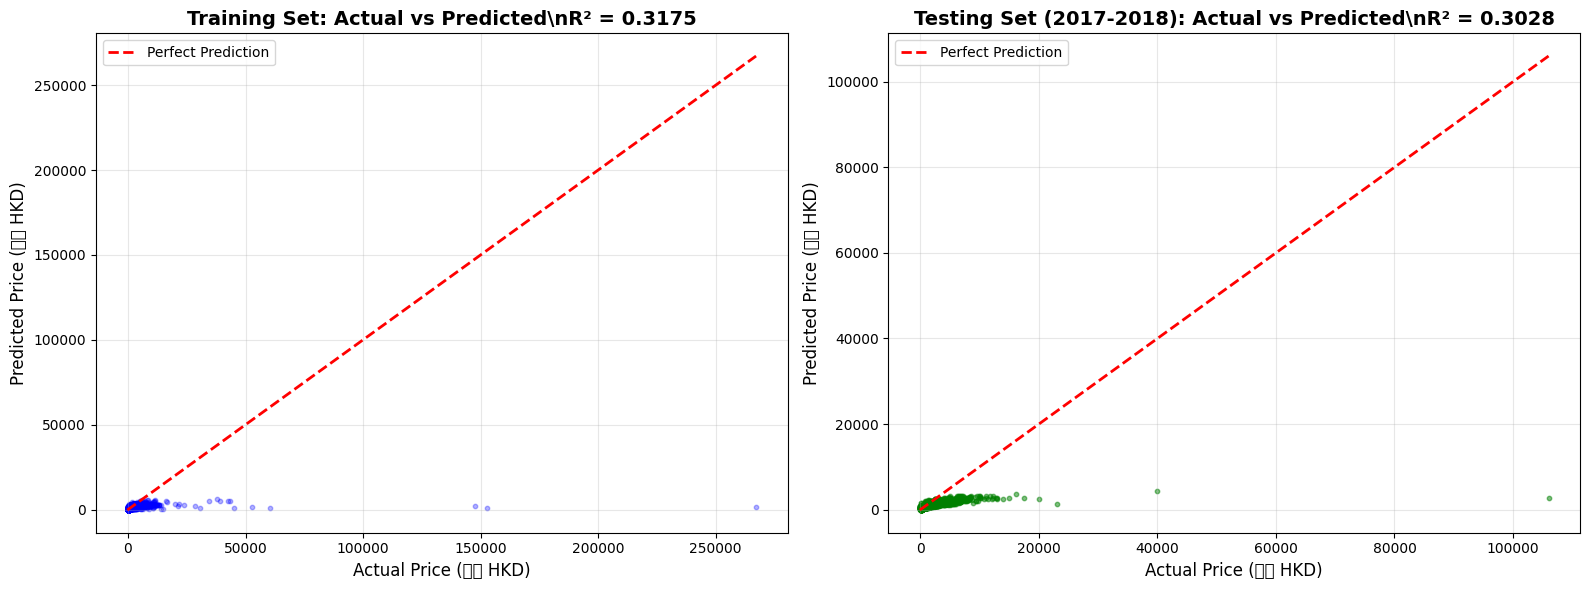

/var/folders/_1/w3rmdmrx14qdr85c4l_crhq80000gn/T/ipykernel_9746/3529383865.py:59: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_1/w3rmdmrx14qdr85c4l_crhq80000gn/T/ipykernel_9746/3529383865.py:59: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


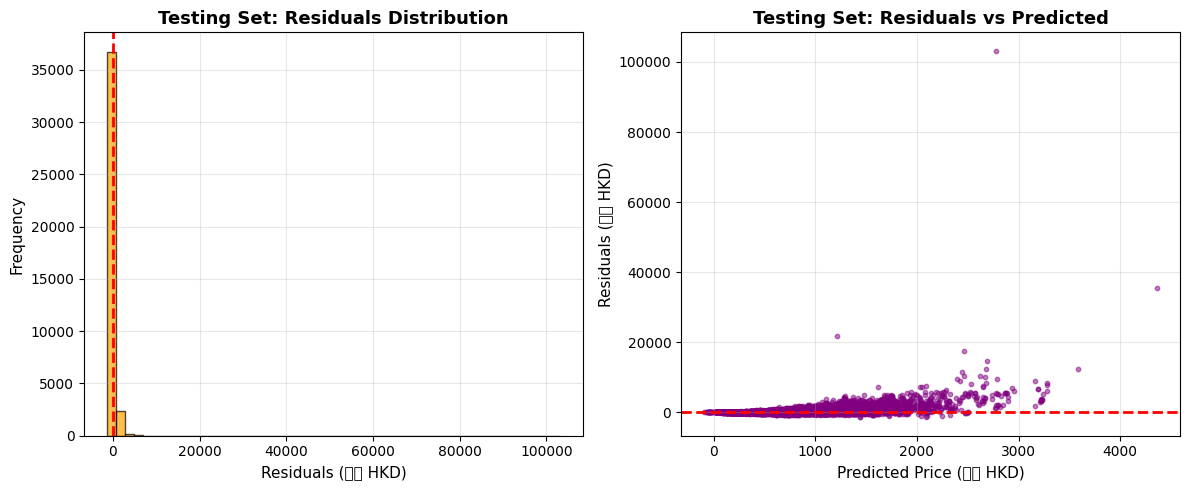

In [60]:
# 10. Visualization: Predicted vs Actual

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Left: Training Set ===
ax1 = axes[0]
ax1.scatter(y_train, y_pred_train, alpha=0.3, s=10, color='blue')
# Perfect prediction line
min_val = min(float(y_train.min()), float(y_pred_train.min()))
max_val = max(float(y_train.max()), float(y_pred_train.max()))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

ax1.set_xlabel('Actual Price (万元 HKD)', fontsize=12)
ax1.set_ylabel('Predicted Price (万元 HKD)', fontsize=12)
ax1.set_title(f'Training Set: Actual vs Predicted\\nR² = {train_r2:.4f}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# === Right: Testing Set ===
ax2 = axes[1]
ax2.scatter(y_test, y_pred_test, alpha=0.5, s=10, color='green')
# Perfect prediction line
min_val = min(float(y_test.min()), float(y_pred_test.min()))
max_val = max(float(y_test.max()), float(y_pred_test.max()))
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

ax2.set_xlabel('Actual Price (万元 HKD)', fontsize=12)
ax2.set_ylabel('Predicted Price (万元 HKD)', fontsize=12)
ax2.set_title(f'Testing Set (2017-2018): Actual vs Predicted\\nR² = {test_r2:.4f}', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual Plot for Testing Set
plt.figure(figsize=(12, 5))

# Residual histogram
residuals_test = y_test - y_pred_test

plt.subplot(1, 2, 1)
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuals (万元 HKD)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Testing Set: Residuals Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# Residual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, alpha=0.5, s=10, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Price (万元 HKD)', fontsize=11)
plt.ylabel('Residuals (万元 HKD)', fontsize=11)
plt.title('Testing Set: Residuals vs Predicted', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [61]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262519 entries, 0 to 1262518
Data columns (total 13 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   Building Location        1262519 non-null  object        
 1   Building Estate          1262519 non-null  object        
 2   District                 1262519 non-null  object        
 3   Building Floor           898371 non-null   float64       
 4   Building Net Area        867970 non-null   float64       
 5   Building Price hkd       1262519 non-null  int64         
 6   Price per net area       867970 non-null   float64       
 7   Transaction date         1262519 non-null  datetime64[ns]
 8   Property_Type            867970 non-null   object        
 9   Property_Economy         1262519 non-null  int64         
 10  Property_Standard        1262519 non-null  int64         
 11  Property_Premium         1262519 non-null  int64         
 12  

In [62]:
# 8. Linear Regression Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*50)
print("Starting Linear Regression Training...")
print("="*50)

# Initialize Model
lr_model = LinearRegression()

# Train Model
lr_model.fit(X_train, y_train)
print("Model Trained Successfully!")

# Make Predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("Predictions Completed.")

# Check Coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0]
})
print("\nModel Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

Starting Linear Regression Training...
Model Trained Successfully!
Predictions Completed.

Model Coefficients:
                   Feature  Coefficient
0           Building Floor     1.991086
1        Building Net Area     1.991086
2         Transaction date     1.991086
3         Property_Economy     1.991086
4        Property_Standard     1.991086
5         Property_Premium     1.991086
6  District_Target_Encoded     1.991086



=== Training Set Evaluation ===
RMSE: 529.12
MAE:  126.93
R2 Score: 0.3175

=== Testing Set Evaluation ===
RMSE: 776.74
MAE:  239.11
R2 Score: 0.3028


AttributeError: 'numpy.int64' object has no attribute 'iloc'

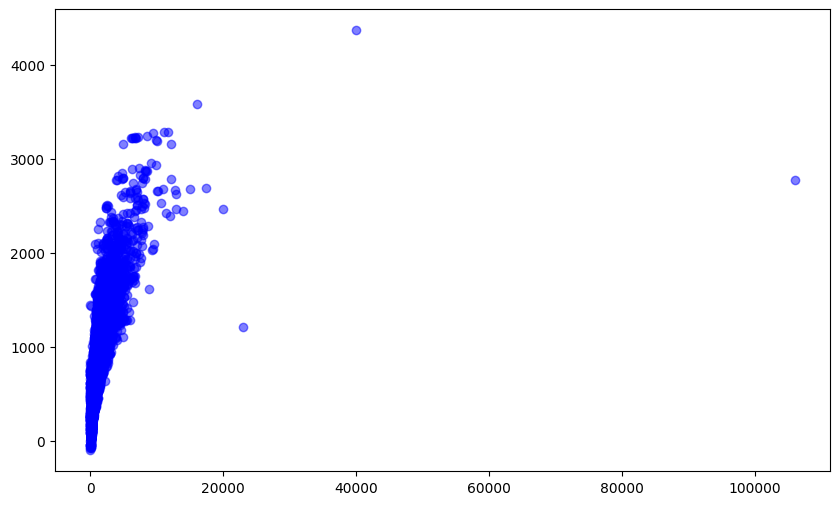

In [63]:
# 9. Model Evaluation

def evaluate_model(y_true, y_pred, set_name="Test"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n=== {set_name} Set Evaluation ===")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE:  {mae:,.2f}")
    print(f"R2 Score: {r2:.4f}")
    return rmse, mae, r2

# Evaluate Train and Test
evaluate_model(y_train, y_pred_train, "Training")
evaluate_model(y_test, y_pred_test, "Testing")

# Visualization: Actual vs Predicted (Test Set)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue', label='Predicted vs Actual')
# Perfect prediction line
min_val = min(y_test.min().iloc[0], y_pred_test.min())
max_val = max(y_test.max().iloc[0], y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price (HKD)')
plt.ylabel('Predicted Price (HKD)')
plt.title('Linear Regression: Actual vs Predicted Prices (Test Set)')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='both') # Prevent scientific notation
plt.show()